In [1]:
# The imports we will need to run Constitutional Control
import matplotlib.pyplot as plt
import torch
from numpy import array, cos, dot, pi, random, sin, zeros
from scipy.stats import multivariate_normal

from promis import ConstitutionalController, DoubtDensity
from promis.geo import CartesianCollection

100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


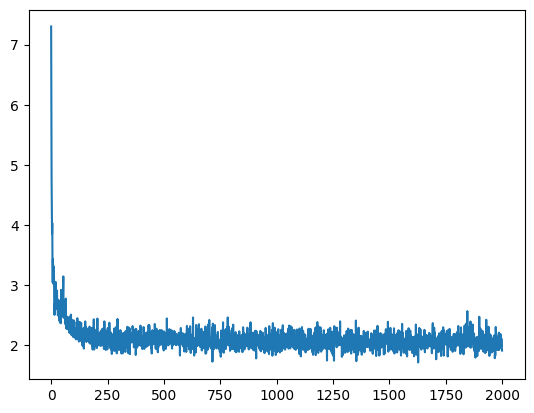

/Volumes/Vault/Repositories/CoCo/venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


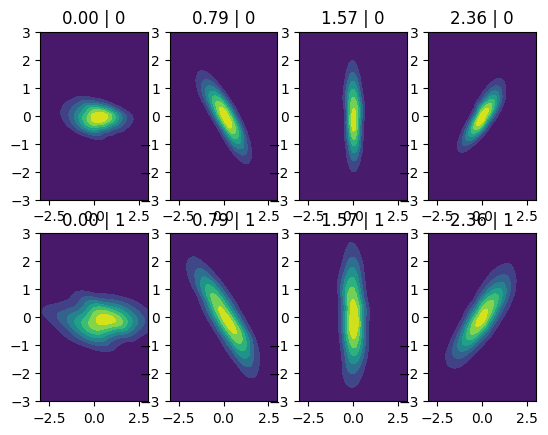

In [2]:
# Select a compute device
devices = ['cpu', 'mps', 'cuda']
device = devices[0]
torch.device(device)
torch.set_default_dtype(torch.float64)

# Conditional density to learn, simulates a turning 2D Gaussian
# with variance depending on controller
def sample_uav_error(controller, heading, n_samples=1000):
    samples = zeros((n_samples, 2))
    for sample in range(n_samples):
        rot = array([
            [cos(heading[sample].item()), -sin(heading[sample].item())],
            [sin(heading[sample].item()), cos(heading[sample].item())]
        ])
        density = multivariate_normal(array([0.0, 0.0]), array([
            [1.0 + controller[sample][0], 0.0],
            [0.0, 0.1 * (1.0 + controller[sample][0])]
        ]))

        samples[sample] = dot(density.rvs(1), rot)

    return torch.from_numpy(samples)

# Setup doubt density training
doubt_space = {
    'controller': {
        'type': 'categorical',
        'number_of_classes': 2
    },
    'heading': {
        'type': 'continuous',
    }
}

doubt_density = DoubtDensity(
    doubt_space=doubt_space,
    number_of_states=2,
    number_of_hidden_features=100,
    number_of_layers=5
)

# Train with synthetic data
number_of_samples = 10000
doubt_space['controller']['values'] = torch.from_numpy(random.choice([0, 1], (number_of_samples, 1)))
doubt_space['heading']['values'] = torch.from_numpy(random.random((number_of_samples, 1)) * pi)
conditional_state_samples = sample_uav_error(doubt_space['controller']['values'], doubt_space['heading']['values'], number_of_samples)

number_of_epochs = 20
batch_size = 100
losses = doubt_density.fit(conditional_state_samples, doubt_space, number_of_epochs, batch_size)

# Show results
plt.plot(range(len(losses)), losses)
plt.show()

fig, ax = plt.subplots(2, 4)
for index, heading in enumerate(array([0, 0.25, 0.5, 0.75]) * pi): 
    for controller in [0, 1]:
        axis = ax[controller, index]
        xline = torch.linspace(-3.0, 3.0, 100)
        yline = torch.linspace(-3.0, 3.0, 100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        states = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            doubt_space['heading']['values'] = torch.tensor([[heading]]).repeat(100 * 100, 1)
            doubt_space['controller']['values'] = torch.tensor([[controller]]).repeat(100 * 100, 1)
            density = doubt_density.prob(states, doubt_space).reshape(100, 100)

        axis.contourf(xgrid.numpy(), ygrid.numpy(), density.numpy())
        axis.set_title(f"{heading:.2f} | {int(controller)}")
plt.show()

Doubt feature heading h = 0.0
Search and scatter path ...


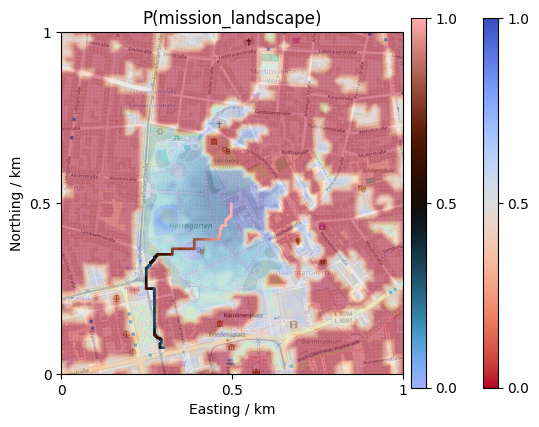

Doubt feature heading h = 0.7853981633974483
Search and scatter path ...


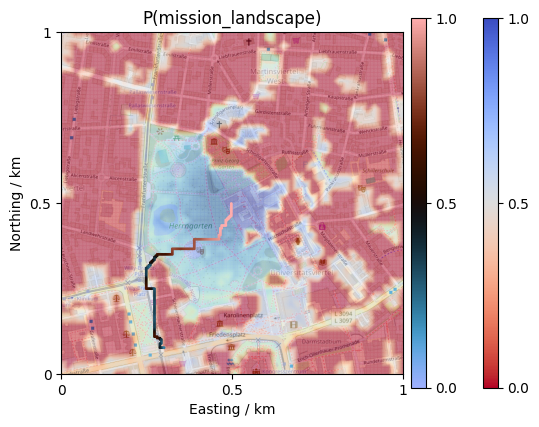

Doubt feature heading h = 1.5707963267948966
Search and scatter path ...


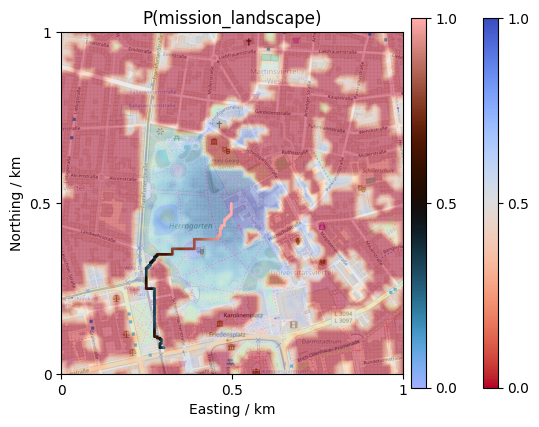

Doubt feature heading h = 2.356194490192345
Search and scatter path ...


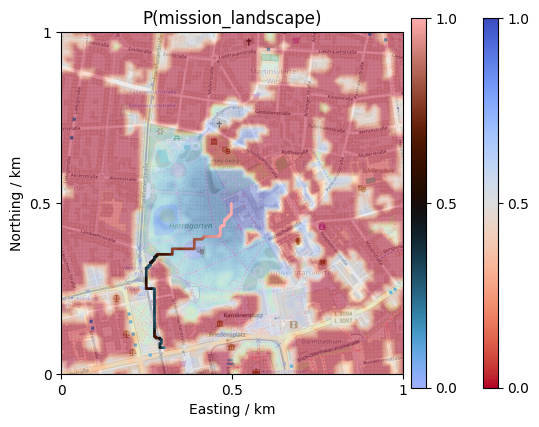

In [5]:
# Load the landscape produced by promis.ipynb and init CoCo
landscape = CartesianCollection.load("data/landscape.pkl")
coco = ConstitutionalController()

# Select different doubt feature values, here we have just one feature velocity
# and use it directly as doubt density parameter
for heading in list(array([0, 0.25, 0.5, 0.75]) * pi):
    print(f"Doubt feature heading h = {heading}")

    doubt_space['heading']['values'] = torch.tensor([[0.0]])
    doubt_space['controller']['values'] = torch.tensor([[1]])
    augmented_landscape = coco.apply_doubt(
        landscape=landscape,
        doubt_density=doubt_density,
        doubt_space=doubt_space,
        number_of_samples=100,
    )

    image = augmented_landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=0.25)
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    print("Search and scatter path ...")
    start = (0.0, 0.0)
    goal = (-200.0, -425.0)
    path = augmented_landscape.search_path(start, goal, cost_model=lambda p: 1.0 - p, value_filter=lambda p: p > 0.3)
    scatter = plt.scatter(
        [n[0] for n in path], [n[1] for n in path], 
        s=1, 
        c=[
            coco.compliance(
                path=path,
                landscape=augmented_landscape, 
                doubt_density=doubt_density, 
                doubt_space=doubt_space,
                number_of_samples=100
            ) 
        ],
        vmin=0, 
        vmax=1, 
        cmap="berlin"
    )
    cbar = plt.colorbar(scatter, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    ticks = [-500, 0, 500]
    labels = ["0", "0.5", "1"]

    plt.xlabel("Easting / km")
    plt.ylabel("Northing / km")
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title("P(mission_landscape)")
    plt.show()